In [1093]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [1094]:
## Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    # Avoid division by zero
    nonzero_idx = y_true != 0
    return np.mean(np.abs((y_true[nonzero_idx] - y_pred[nonzero_idx]) / y_true[nonzero_idx])) * 100

In [1095]:
df = pd.read_excel("AIB_History_Training_2014-2020.xlsx", sheet_name='HistoricalTransactions')
df = df.drop(columns=["FileFolder", "FileName", "Report_Title", "Report_RunDate", "Report_AsOfDate", "Currency", "Institution", "Branch", "TransactionBackdateFlag", "TransactionCode", "TransactionGroup"])
df.set_index("Report_TransactionEffectiveDate", inplace=True)
df

,TransactionAmount
Report_TransactionEffectiveDate,
2013-12-30,-972.619715
2013-12-30,-75.956876
2013-12-30,127.430470
2013-12-30,-38.300469
2013-12-30,-117.467137
...,...
2020-12-31,-19.288367
2020-12-31,-832.837608
2020-12-31,-103.691425


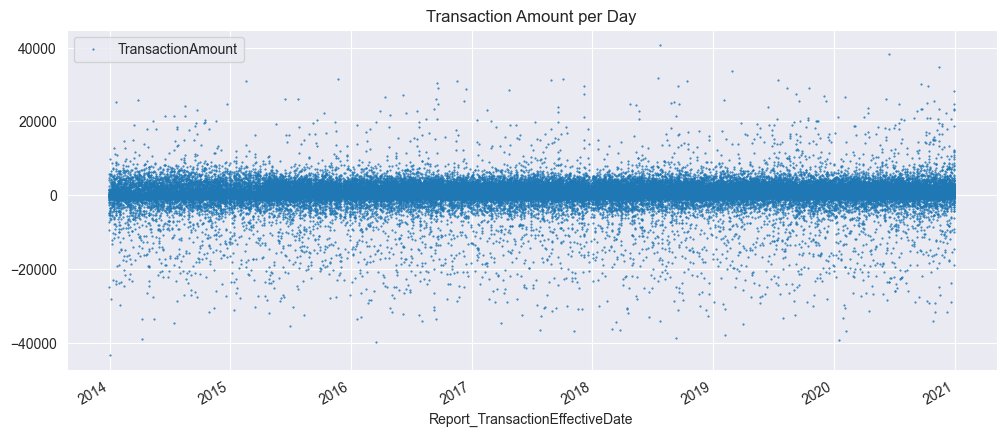

In [1096]:
## Each Transaction Value
colour_pal = sns.color_palette()
df.plot(style='.', ms=1, figsize=(12, 5), color=colour_pal[0], title="Transaction Amount per Day" )
plt.show()

In [1097]:
## Total Transaction value per day
df = df.groupby(["Report_TransactionEffectiveDate"])["TransactionAmount"].sum().asfreq('D').ffill().bfill().to_frame()
df

,TransactionAmount
Report_TransactionEffectiveDate,
2013-12-30,-1076.913729
2013-12-31,-41733.273687
2014-01-01,-3465.890925
2014-01-02,-45506.653405
2014-01-03,-18386.381900
...,...
2020-12-27,1763.692730
2020-12-28,1763.692730
2020-12-29,82156.304473


In [1098]:
# Check for extreme outliers
q1, q3 = df['TransactionAmount'].quantile([0.25, 0.75])
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df[(df['TransactionAmount'] < lower_bound) | (df['TransactionAmount'] > upper_bound)]
print("Outliers detected:", len(outliers))

Outliers detected: 98


In [1099]:
df['TransactionAmount'] = np.clip(df['TransactionAmount'], lower_bound, upper_bound)

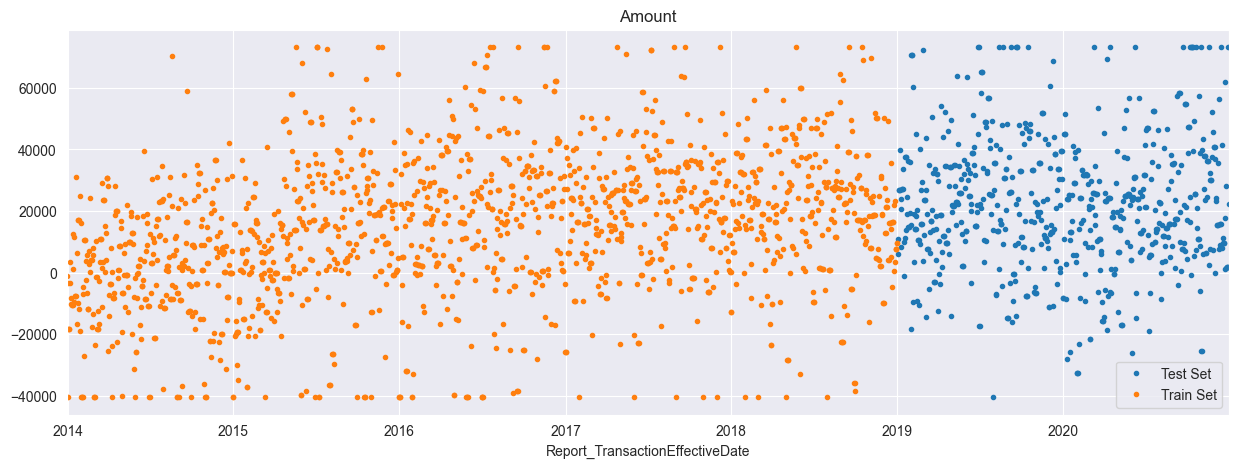

In [1100]:
split_date = '1-Jan-2019'
data_train = df.loc[df.index <= split_date].copy()
data_test = df.loc[df.index > split_date].copy()

data_test.rename(columns={'TransactionAmount': 'Test Set'}).join(data_train.rename(columns={'TransactionAmount': 'Train Set'}), how='outer').plot(figsize=(15, 5), title="Amount", style='.')
plt.show()

In [1101]:
shift = abs(data_train['TransactionAmount'].min()) + 1  # Ensure all values are positive
data_train['TransactionAmount_shifted'] = data_train['TransactionAmount'] + shift  # Shift data
data_train['TransactionAmount_log'] = np.log1p(data_train['TransactionAmount_shifted'])  # Apply log

shift = abs(data_test['TransactionAmount'].min()) + 1  # Ensure all values are positive
data_test['TransactionAmount_shifted'] = data_test['TransactionAmount'] + shift  # Shift data
data_test['TransactionAmount_log'] = np.log1p(data_test['TransactionAmount_shifted'])  # Apply log

In [1102]:
data_train_prophet = data_train.reset_index().rename(columns={'Report_TransactionEffectiveDate': 'ds', 'TransactionAmount_log': 'y'})
data_train_prophet

,ds,TransactionAmount,TransactionAmount_shifted,y
0,2013-12-30,-1076.913729,39341.466845,10.580060
1,2013-12-31,-40417.380574,1.000000,0.693147
2,2014-01-01,-3465.890925,36952.489649,10.517415
3,2014-01-02,-40417.380574,1.000000,0.693147
4,2014-01-03,-18386.381900,22031.998674,10.000297
...,...,...,...,...
1824,2018-12-28,7577.044740,47995.425314,10.778882
1825,2018-12-29,7577.044740,47995.425314,10.778882
1826,2018-12-30,7577.044740,47995.425314,10.778882
1827,2018-12-31,9481.245786,49899.626360,10.817789


In [1103]:
%%time
model = Prophet(
    seasonality_prior_scale=1,
    yearly_seasonality=10,
    weekly_seasonality=5,
    daily_seasonality=False,
    changepoint_prior_scale=0.0007,
    changepoint_range=0.9,
    seasonality_mode='multiplicative',
    interval_width=0.95,
)

model.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=1)
model.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=1)
model.add_seasonality(name='yearly', period=365.25, fourier_order=10, prior_scale=1)

model.fit(data_train_prophet)

13:39:46 - cmdstanpy - INFO - Chain [1] start processing
13:39:46 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 266 ms
Wall time: 539 ms


In [1104]:
data_test_prophet = data_test.reset_index().rename(columns={'Report_TransactionEffectiveDate': 'ds', 'TransactionAmount_log': 'y'})
data_test_predict = model.predict(data_test_prophet)
data_test_predict.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,monthly,monthly_lower,monthly_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2019-01-02,10.720430,5.519718,12.084733,10.720430,10.720430,-0.120815,-0.120815,-0.120815,-0.177430,...,-0.004499,-0.004499,-0.004499,-0.052116,-0.052116,-0.052116,0.0,0.0,0.0,8.818309
1,2019-01-03,10.720613,5.572757,12.583610,10.720613,10.720613,-0.100874,-0.100874,-0.100874,-0.153225,...,-0.001991,-0.001991,-0.001991,-0.050360,-0.050360,-0.050360,0.0,0.0,0.0,9.077947
2,2019-01-04,10.720795,6.079971,12.604236,10.720795,10.720795,-0.061963,-0.061963,-0.061963,-0.122909,...,-0.012921,-0.012921,-0.012921,-0.048025,-0.048025,-0.048025,0.0,0.0,0.0,9.403116
3,2019-01-05,10.720978,6.544633,13.513709,10.720978,10.720978,-0.022987,-0.022987,-0.022987,-0.078820,...,-0.010637,-0.010637,-0.010637,-0.045196,-0.045196,-0.045196,0.0,0.0,0.0,9.875954
4,2019-01-06,10.721160,6.797119,13.441638,10.721160,10.721160,0.002509,0.002509,0.002509,-0.046925,...,-0.007465,-0.007465,-0.007465,-0.041969,-0.041969,-0.041969,0.0,0.0,0.0,10.218069


In [1105]:
data_test_predict['yhat_original'] = np.exp(data_test_predict['yhat']) - shift
data_test_predict

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,monthly,monthly_lower,monthly_upper,multiplicative_terms,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,yhat_original
0,2019-01-02,10.720430,5.519718,12.084733,10.720430,10.720430,-0.120815,-0.120815,-0.120815,-0.177430,...,-0.004499,-0.004499,-0.052116,-0.052116,-0.052116,0.0,0.0,0.0,8.818309,-33661.548172
1,2019-01-03,10.720613,5.572757,12.583610,10.720613,10.720613,-0.100874,-0.100874,-0.100874,-0.153225,...,-0.001991,-0.001991,-0.050360,-0.050360,-0.050360,0.0,0.0,0.0,9.077947,-31658.418318
2,2019-01-04,10.720795,6.079971,12.604236,10.720795,10.720795,-0.061963,-0.061963,-0.061963,-0.122909,...,-0.012921,-0.012921,-0.048025,-0.048025,-0.048025,0.0,0.0,0.0,9.403116,-28292.273509
3,2019-01-05,10.720978,6.544633,13.513709,10.720978,10.720978,-0.022987,-0.022987,-0.022987,-0.078820,...,-0.010637,-0.010637,-0.045196,-0.045196,-0.045196,0.0,0.0,0.0,9.875954,-20961.546321
4,2019-01-06,10.721160,6.797119,13.441638,10.721160,10.721160,0.002509,0.002509,0.002509,-0.046925,...,-0.007465,-0.007465,-0.041969,-0.041969,-0.041969,0.0,0.0,0.0,10.218069,-13024.649382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,2020-12-27,10.852715,7.339401,13.848928,10.852710,10.852721,0.029035,0.029035,0.029035,-0.027434,...,-0.007465,-0.007465,-0.049004,-0.049004,-0.049004,0.0,0.0,0.0,10.554981,-2050.312743
726,2020-12-28,10.852898,7.625157,14.140686,10.852892,10.852903,0.031704,0.031704,0.031704,0.014001,...,0.033583,0.033583,-0.051286,-0.051286,-0.051286,0.0,0.0,0.0,11.004851,19746.939740
727,2020-12-29,10.853080,7.340863,13.886643,10.853075,10.853086,0.030949,0.030949,0.030949,-0.017920,...,0.003929,0.003929,-0.052798,-0.052798,-0.052798,0.0,0.0,0.0,10.658598,2138.534917
728,2020-12-30,10.853263,6.995183,13.778165,10.853257,10.853268,0.014323,0.014323,0.014323,-0.043711,...,-0.004499,-0.004499,-0.053535,-0.053535,-0.053535,0.0,0.0,0.0,10.378859,-8246.157686


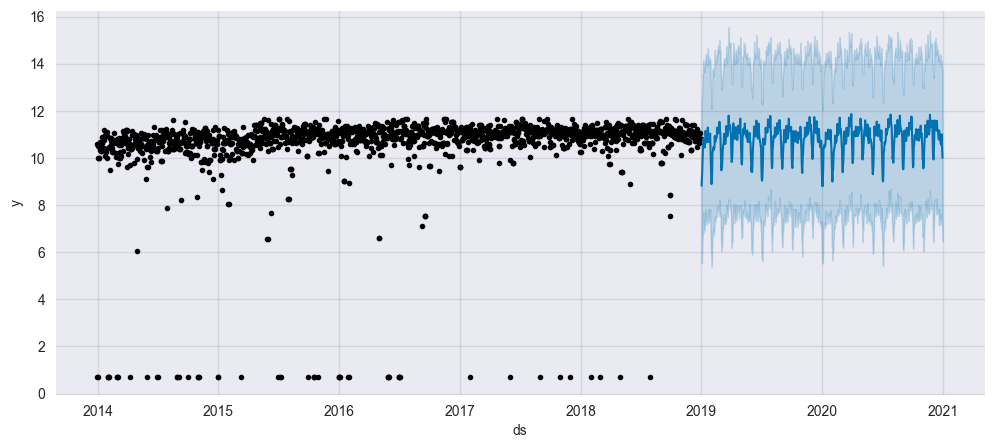

In [1106]:
fig, ax = plt.subplots(figsize=(12, 5))
fig = model.plot(data_test_predict, ax=ax)
plt.show()

In [1107]:
data_test

,TransactionAmount,TransactionAmount_shifted,TransactionAmount_log
Report_TransactionEffectiveDate,,,
2019-01-02,11085.985373,51504.365946,10.849441
2019-01-03,5997.282482,46415.663056,10.745414
2019-01-04,26741.238955,67159.619528,11.114842
2019-01-05,26741.238955,67159.619528,11.114842
2019-01-06,26741.238955,67159.619528,11.114842
...,...,...,...
2020-12-27,1763.692730,42182.073304,10.649774
2020-12-28,1763.692730,42182.073304,10.649774
2020-12-29,73263.818051,113682.198625,11.641171


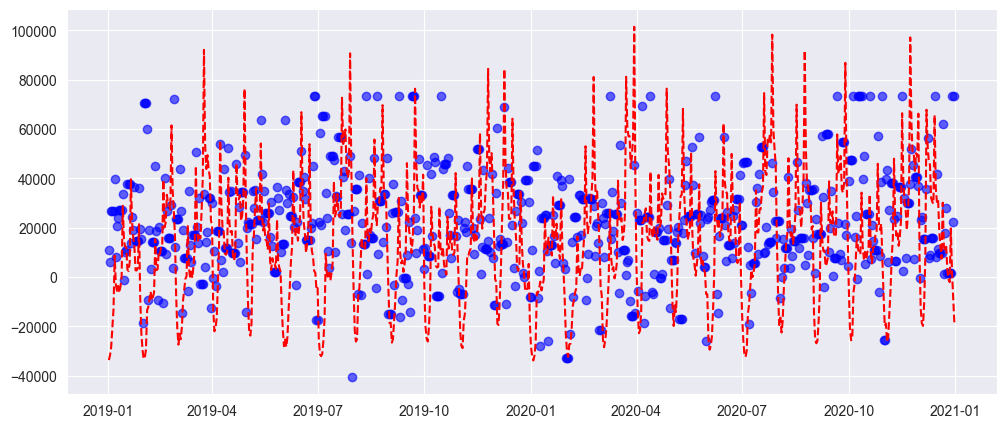

In [1108]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.scatter(data_test.index, data_test["TransactionAmount"], color='blue', label="Actual Data", alpha=0.6)
ax.plot(data_test.index, data_test_predict["yhat_original"], color='red', linestyle='dashed', label="Predicted")
plt.show()

In [1109]:
data_test_predict

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,monthly,monthly_lower,monthly_upper,multiplicative_terms,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,yhat_original
0,2019-01-02,10.720430,5.519718,12.084733,10.720430,10.720430,-0.120815,-0.120815,-0.120815,-0.177430,...,-0.004499,-0.004499,-0.052116,-0.052116,-0.052116,0.0,0.0,0.0,8.818309,-33661.548172
1,2019-01-03,10.720613,5.572757,12.583610,10.720613,10.720613,-0.100874,-0.100874,-0.100874,-0.153225,...,-0.001991,-0.001991,-0.050360,-0.050360,-0.050360,0.0,0.0,0.0,9.077947,-31658.418318
2,2019-01-04,10.720795,6.079971,12.604236,10.720795,10.720795,-0.061963,-0.061963,-0.061963,-0.122909,...,-0.012921,-0.012921,-0.048025,-0.048025,-0.048025,0.0,0.0,0.0,9.403116,-28292.273509
3,2019-01-05,10.720978,6.544633,13.513709,10.720978,10.720978,-0.022987,-0.022987,-0.022987,-0.078820,...,-0.010637,-0.010637,-0.045196,-0.045196,-0.045196,0.0,0.0,0.0,9.875954,-20961.546321
4,2019-01-06,10.721160,6.797119,13.441638,10.721160,10.721160,0.002509,0.002509,0.002509,-0.046925,...,-0.007465,-0.007465,-0.041969,-0.041969,-0.041969,0.0,0.0,0.0,10.218069,-13024.649382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,2020-12-27,10.852715,7.339401,13.848928,10.852710,10.852721,0.029035,0.029035,0.029035,-0.027434,...,-0.007465,-0.007465,-0.049004,-0.049004,-0.049004,0.0,0.0,0.0,10.554981,-2050.312743
726,2020-12-28,10.852898,7.625157,14.140686,10.852892,10.852903,0.031704,0.031704,0.031704,0.014001,...,0.033583,0.033583,-0.051286,-0.051286,-0.051286,0.0,0.0,0.0,11.004851,19746.939740
727,2020-12-29,10.853080,7.340863,13.886643,10.853075,10.853086,0.030949,0.030949,0.030949,-0.017920,...,0.003929,0.003929,-0.052798,-0.052798,-0.052798,0.0,0.0,0.0,10.658598,2138.534917
728,2020-12-30,10.853263,6.995183,13.778165,10.853257,10.853268,0.014323,0.014323,0.014323,-0.043711,...,-0.004499,-0.004499,-0.053535,-0.053535,-0.053535,0.0,0.0,0.0,10.378859,-8246.157686


In [1110]:
data_test

,TransactionAmount,TransactionAmount_shifted,TransactionAmount_log
Report_TransactionEffectiveDate,,,
2019-01-02,11085.985373,51504.365946,10.849441
2019-01-03,5997.282482,46415.663056,10.745414
2019-01-04,26741.238955,67159.619528,11.114842
2019-01-05,26741.238955,67159.619528,11.114842
2019-01-06,26741.238955,67159.619528,11.114842
...,...,...,...
2020-12-27,1763.692730,42182.073304,10.649774
2020-12-28,1763.692730,42182.073304,10.649774
2020-12-29,73263.818051,113682.198625,11.641171


In [1111]:
np.sqrt(mean_squared_error(y_true=data_test["TransactionAmount"], y_pred = data_test_predict["yhat_original"]))

31468.99963119245

In [1112]:
mean_absolute_error(y_true=data_test['TransactionAmount'],
                   y_pred=data_test_predict['yhat_original'])

24281.83246339483

In [1113]:
mean_absolute_percentage_error(y_true=data_test['TransactionAmount'],
                   y_pred=data_test_predict['yhat_original'])

245.50085254823446

In [1114]:
last_date_in_test = data_test.index[-1]
last_date_in_test

Timestamp('2020-12-31 00:00:00')

In [1115]:
future = pd.date_range(start=last_date_in_test + pd.Timedelta(days=1), periods=90, freq='D')
future_df = pd.DataFrame({'ds': future}) 

forecast_future = model.predict(future_df)
forecast_future

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,monthly,monthly_lower,monthly_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2021-01-01,10.853628,5.904398,12.815674,10.853628,10.853628,-0.071063,-0.071063,-0.071063,-0.136737,...,-0.012921,-0.012921,-0.012921,-0.052753,-0.052753,-0.052753,0.0,0.0,0.0,9.369538
1,2021-01-02,10.853810,5.630754,12.425169,10.853810,10.853810,-0.109643,-0.109643,-0.109643,-0.171595,...,-0.010637,-0.010637,-0.010637,-0.051315,-0.051315,-0.051315,0.0,0.0,0.0,8.991349
2,2021-01-03,10.853993,5.530985,12.051055,10.853993,10.853993,-0.120815,-0.120815,-0.120815,-0.177540,...,-0.007465,-0.007465,-0.007465,-0.049260,-0.049260,-0.049260,0.0,0.0,0.0,8.926979
3,2021-01-04,10.854175,6.378476,13.077427,10.854175,10.854175,-0.100874,-0.100874,-0.100874,-0.113957,...,0.033583,0.033583,0.033583,-0.046666,-0.046666,-0.046666,0.0,0.0,0.0,9.617270
4,2021-01-05,10.854358,6.748076,13.348723,10.854358,10.854358,-0.061963,-0.061963,-0.061963,-0.101660,...,0.003929,0.003929,0.003929,-0.043626,-0.043626,-0.043626,0.0,0.0,0.0,9.750902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2021-03-27,10.869137,8.145260,14.559399,10.869137,10.869137,0.034899,0.034899,0.034899,0.057177,...,-0.010637,-0.010637,-0.010637,0.032915,0.032915,0.032915,0.0,0.0,0.0,11.490599
86,2021-03-28,10.869319,8.158404,14.685297,10.869319,10.869320,0.029514,0.029514,0.029514,0.057618,...,-0.007465,-0.007465,-0.007465,0.035569,0.035569,0.035569,0.0,0.0,0.0,11.495591
87,2021-03-29,10.869502,8.574498,15.478665,10.869502,10.869502,0.030049,0.030049,0.030049,0.101255,...,0.033583,0.033583,0.033583,0.037623,0.037623,0.037623,0.0,0.0,0.0,11.970095
88,2021-03-30,10.869684,8.506622,15.219344,10.869684,10.869685,0.032574,0.032574,0.032574,0.075532,...,0.003929,0.003929,0.003929,0.039029,0.039029,0.039029,0.0,0.0,0.0,11.690698


In [1116]:
forecast_future['yhat_original'] = np.exp(forecast_future['yhat']) - shift
forecast_future

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,monthly,monthly_lower,monthly_upper,multiplicative_terms,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,yhat_original
0,2021-01-01,10.853628,5.904398,12.815674,10.853628,10.853628,-0.071063,-0.071063,-0.071063,-0.136737,...,-0.012921,-0.012921,-0.052753,-0.052753,-0.052753,0.0,0.0,0.0,9.369538,-28692.686130
1,2021-01-02,10.853810,5.630754,12.425169,10.853810,10.853810,-0.109643,-0.109643,-0.109643,-0.171595,...,-0.010637,-0.010637,-0.051315,-0.051315,-0.051315,0.0,0.0,0.0,8.991349,-32385.094377
2,2021-01-03,10.853993,5.530985,12.051055,10.853993,10.853993,-0.120815,-0.120815,-0.120815,-0.177540,...,-0.007465,-0.007465,-0.049260,-0.049260,-0.049260,0.0,0.0,0.0,8.926979,-32885.904479
3,2021-01-04,10.854175,6.378476,13.077427,10.854175,10.854175,-0.100874,-0.100874,-0.100874,-0.113957,...,0.033583,0.033583,-0.046666,-0.046666,-0.046666,0.0,0.0,0.0,9.617270,-25396.397221
4,2021-01-05,10.854358,6.748076,13.348723,10.854358,10.854358,-0.061963,-0.061963,-0.061963,-0.101660,...,0.003929,0.003929,-0.043626,-0.043626,-0.043626,0.0,0.0,0.0,9.750902,-23248.676882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2021-03-27,10.869137,8.145260,14.559399,10.869137,10.869137,0.034899,0.034899,0.034899,0.057177,...,-0.010637,-0.010637,0.032915,0.032915,0.032915,0.0,0.0,0.0,11.490599,57373.705842
86,2021-03-28,10.869319,8.158404,14.685297,10.869319,10.869320,0.029514,0.029514,0.029514,0.057618,...,-0.007465,-0.007465,0.035569,0.035569,0.035569,0.0,0.0,0.0,11.495591,57863.071932
87,2021-03-29,10.869502,8.574498,15.478665,10.869502,10.869502,0.030049,0.030049,0.030049,0.101255,...,0.033583,0.033583,0.037623,0.037623,0.037623,0.0,0.0,0.0,11.970095,117541.259548
88,2021-03-30,10.869684,8.506622,15.219344,10.869684,10.869685,0.032574,0.032574,0.032574,0.075532,...,0.003929,0.003929,0.039029,0.039029,0.039029,0.0,0.0,0.0,11.690698,79036.923778


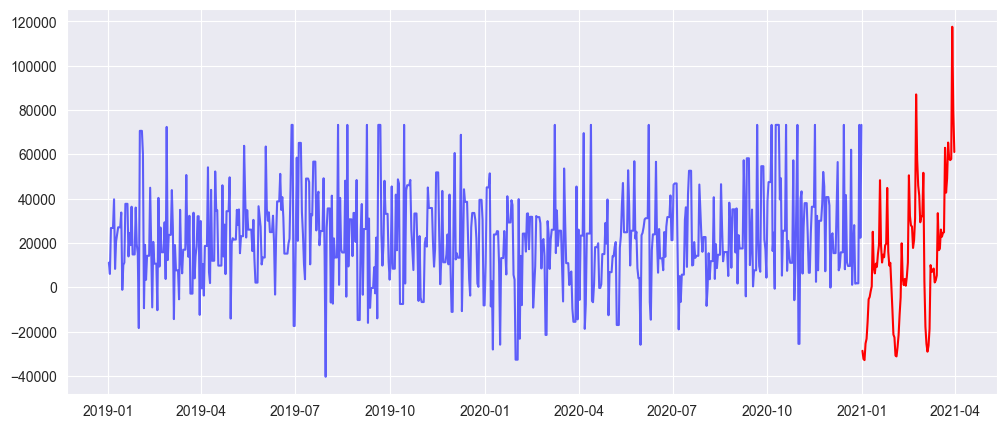

In [1117]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(data_test.index, data_test["TransactionAmount"], color='blue', label="Actual Data", alpha=0.6)
ax.plot(forecast_future['ds'], forecast_future["yhat_original"], color='red', label="Predicted")
plt.show()

In [1118]:
export_df = pd.DataFrame({
    'GroupName': 'Precision Analyst',
    'Date': forecast_future['ds'].dt.date,
    'TotalPredictedAmount': forecast_future['yhat_original']
})

# Round the predicted amounts to 2 decimal places
export_df['TotalPredictedAmount'] = export_df['TotalPredictedAmount'].round(2)

# Export to Excel
export_df.to_excel('forecast_results_prophet_2.xlsx', index=False)

# Display the first few rows of the exported data
print("Preview of exported data:")
print(export_df.head())

Preview of exported data:
           GroupName        Date  TotalPredictedAmount
0  Precision Analyst  2021-01-01             -28692.69
1  Precision Analyst  2021-01-02             -32385.09
2  Precision Analyst  2021-01-03             -32885.90
3  Precision Analyst  2021-01-04             -25396.40
4  Precision Analyst  2021-01-05             -23248.68
